In [81]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import glob
import os

In [ ]:
# normalization constants for ResetNet
IMAGE_NET_MEAN = [0.485, 0.456, 0.406]
IMAGE_NET_STD = [0.229, 0.224, 0.225]

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, image_size=(224, 224), train=True):
        """
        Args:
            root_dir (str): Directory with all category folders
            image_size (tuple): Desired output size (height, width)
            train (bool): If True, create dataset for training (with augmentations)
        """
        self.img_dir = img_dir
        self.image_size = image_size
        self.train = train
        
        # Get all image paths and their corresponding labels
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}
        
        # List all category folders
        categories = sorted([d for d in os.listdir(img_dir) 
                           if os.path.isdir(os.path.join(img_dir, d))])
        
        # Create class to index mapping
        for idx, category in enumerate(categories):
            self.class_to_idx[category] = idx
            
            # Get all images in this category
            category_path = os.path.join(img_dir, category)
            image_files = glob.glob(os.path.join(category_path, '*.[jp][pn][gf]'))  # matches .jpg, .png, .jpeg
            
            self.image_paths.extend(image_files)
            self.labels.extend([idx] * len(image_files))

        # Define transforms
        if self.train:
            self.transform = transforms.Compose([
                transforms.Resize(self.image_size),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                transforms.ToTensor(),
                transforms.Normalize(mean=IMAGE_NET_MEAN,
                                  std=IMAGE_NET_STD)
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(self.image_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the image to fetch
        Returns:
            tuple: (image, label) where label is the class index
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_paths[idx]
        
        try:
            # Open and convert image to RGB (handles grayscale images too)
            image = Image.open(img_path).convert('RGB')
            
            # Apply transforms
            image = self.transform(image)
            
            # Get label
            label = self.labels[idx]
            
            return image, label
            
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            # Return a zero tensor and the label if image loading fails
            return torch.zeros((3, *self.image_size)), self.labels[idx]

    def get_class_names(self):
        """Returns a list of class names"""
        return list(self.class_to_idx.keys())

In [83]:
DATASET_DIR = r'datasets/MY2'
TRAIN_DIR = os.path.join(DATASET_DIR, 'TRAIN')
VAL_DIR = os.path.join(DATASET_DIR, 'VAL')
TEST_DIR = os.path.join(DATASET_DIR, 'TEST')

BATCH_SIZE = 1
IMAGE_SIZE = (224, 224)
NUM_WORKERS = 0

In [84]:
train_dataset = CustomImageDataset(TRAIN_DIR, image_size=IMAGE_SIZE, train=True)
val_dataset = CustomImageDataset(VAL_DIR, image_size=IMAGE_SIZE, train=False)
test_dataset = CustomImageDataset(TEST_DIR, image_size=IMAGE_SIZE, train=False)


# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS,
    pin_memory = True
)

val_loader = DataLoader(
    val_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = NUM_WORKERS,
    pin_memory = True
)

test_loader = DataLoader(
    test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = NUM_WORKERS,
    pin_memory = True
)
    

In [85]:
# Print dataset information
print(f"Number of classes: {len(train_loader.dataset.get_class_names())}")
print(f"Class names: {train_loader.dataset.get_class_names()}")
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(val_loader.dataset)}")
print(f"Number of test samples: {len(test_loader.dataset)}")

Number of classes: 5
Class names: ['BEER_CANS', 'OTHER', 'PET_BOTTLES', 'SHAMPOO_BOTTLES', 'YOGHURT_CUPS']
Number of training samples: 81
Number of validation samples: 33
Number of test samples: 10


**MODEL TRAINING**

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader
import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [87]:
class ImageClassifier(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(ImageClassifier, self).__init__()
        # Load pretrained ResNet18
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT if pretrained else None)
        
        # Replace the final fully connected layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

def train_model(train_loader, val_loader, num_classes, num_epochs=20, learning_rate=0.001, 
                device='cuda', model_save_dir='trained_models'):
    """
    Train the model using transfer learning with ResNet18
    
    Args:
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_classes: Number of classes in the dataset
        num_epochs: Number of training epochs
        learning_rate: Initial learning rate
        device: Device to train on ('cuda' or 'cpu')
        model_save_path: Path to save the best model
    """
    os.makedirs(model_save_dir, exist_ok=True)

    # Initialize model
    model = ImageClassifier(num_classes=num_classes)
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    # Using different learning rates for pretrained layers and new layers
    optimizer = optim.AdamW([
        {'params': model.model.fc.parameters(), 'lr': learning_rate},
        {'params': [p for name, p in model.named_parameters() if 'fc' not in name], 
         'lr': learning_rate/10}
    ])
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', 
                                                    factor=0.5, patience=3)
    
    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'best_epoch': 0, 'best_acc': 0.0
    }
    
    # Training loop
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_bar = tqdm(train_loader, desc='Training')
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            train_bar.set_postfix({
                'loss': train_loss/train_total, 
                'acc': 100.*train_correct/train_total
            })
        
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = 100. * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc='Validation')
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                
                # Update progress bar
                val_bar.set_postfix({
                    'loss': val_loss/val_total, 
                    'acc': 100.*val_correct/val_total
                })
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100. * val_correct / val_total
        
        # Update learning rate
        scheduler.step(val_acc)
        
        model_save_path = os.path.join(model_save_dir, f'model_{epoch}.pth')
        
        # Save best model
        if val_acc > history['best_acc']:
            history['best_acc'] = val_acc
            history['best_epoch'] = epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': history['best_acc'],
            }, model_save_path)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print epoch results
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%')
        print(f'Best Val Acc: {history["best_acc"]:.2f}% at epoch {history["best_epoch"]+1}')
    
    return model, history

In [88]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


In [89]:
num_classes = len(train_loader.dataset.get_class_names())

# Train the model
model, history = train_model(
    train_loader = train_loader,
    val_loader = val_loader,
    num_classes = num_classes,
    num_epochs = 20,
    learning_rate = 0.001,
    device = DEVICE,
    model_save_dir = 'runs/dec_1'
)


Epoch 1/20


Validation: 100%|██████████| 33/33 [00:00<00:00, 73.66it/s, loss=1.49, acc=51.5]


Train Loss: 1.7639 Acc: 28.40%
Val Loss: 1.4876 Acc: 51.52%
Best Val Acc: 51.52% at epoch 1

Epoch 2/20


Validation: 100%|██████████| 33/33 [00:00<00:00, 68.00it/s, loss=1.6, acc=39.4] 


Train Loss: 1.5636 Acc: 37.04%
Val Loss: 1.5991 Acc: 39.39%
Best Val Acc: 51.52% at epoch 1

Epoch 3/20


Validation: 100%|██████████| 33/33 [00:00<00:00, 83.06it/s, loss=1.61, acc=30.3]


Train Loss: 1.6753 Acc: 32.10%
Val Loss: 1.6051 Acc: 30.30%
Best Val Acc: 51.52% at epoch 1

Epoch 4/20


Validation: 100%|██████████| 33/33 [00:00<00:00, 54.40it/s, loss=1.75, acc=18.2]


Train Loss: 1.5043 Acc: 39.51%
Val Loss: 1.7538 Acc: 18.18%
Best Val Acc: 51.52% at epoch 1

Epoch 5/20


Validation: 100%|██████████| 33/33 [00:00<00:00, 37.84it/s, loss=1.8, acc=36.4] 


Train Loss: 1.5251 Acc: 41.98%
Val Loss: 1.7960 Acc: 36.36%
Best Val Acc: 51.52% at epoch 1

Epoch 6/20


Validation: 100%|██████████| 33/33 [00:00<00:00, 79.05it/s, loss=2.1, acc=6.06] 


Train Loss: 1.1572 Acc: 59.26%
Val Loss: 2.1023 Acc: 6.06%
Best Val Acc: 51.52% at epoch 1

Epoch 7/20


Validation: 100%|██████████| 33/33 [00:00<00:00, 74.46it/s, loss=2.18, acc=18.2]


Train Loss: 1.0527 Acc: 65.43%
Val Loss: 2.1787 Acc: 18.18%
Best Val Acc: 51.52% at epoch 1

Epoch 8/20


Validation: 100%|██████████| 33/33 [00:00<00:00, 71.87it/s, loss=2.32, acc=33.3]


Train Loss: 0.9051 Acc: 72.84%
Val Loss: 2.3201 Acc: 33.33%
Best Val Acc: 51.52% at epoch 1

Epoch 9/20


Validation: 100%|██████████| 33/33 [00:00<00:00, 79.87it/s, loss=2.5, acc=9.09] 


Train Loss: 0.8702 Acc: 71.60%
Val Loss: 2.4966 Acc: 9.09%
Best Val Acc: 51.52% at epoch 1

Epoch 10/20


Validation: 100%|██████████| 33/33 [00:00<00:00, 83.15it/s, loss=2.33, acc=15.2]


Train Loss: 0.6675 Acc: 80.25%
Val Loss: 2.3346 Acc: 15.15%
Best Val Acc: 51.52% at epoch 1

Epoch 11/20


Validation: 100%|██████████| 33/33 [00:00<00:00, 89.65it/s, loss=2.55, acc=15.2]


Train Loss: 0.5779 Acc: 90.12%
Val Loss: 2.5527 Acc: 15.15%
Best Val Acc: 51.52% at epoch 1

Epoch 12/20


Validation: 100%|██████████| 33/33 [00:00<00:00, 90.78it/s, loss=2.76, acc=18.2]


Train Loss: 0.5458 Acc: 87.65%
Val Loss: 2.7621 Acc: 18.18%
Best Val Acc: 51.52% at epoch 1

Epoch 13/20


Validation: 100%|██████████| 33/33 [00:00<00:00, 76.55it/s, loss=2.88, acc=15.2]


Train Loss: 0.4640 Acc: 93.83%
Val Loss: 2.8812 Acc: 15.15%
Best Val Acc: 51.52% at epoch 1

Epoch 14/20


Validation: 100%|██████████| 33/33 [00:00<00:00, 74.65it/s, loss=2.66, acc=9.09]


Train Loss: 0.4143 Acc: 100.00%
Val Loss: 2.6627 Acc: 9.09%
Best Val Acc: 51.52% at epoch 1

Epoch 15/20


Validation: 100%|██████████| 33/33 [00:00<00:00, 77.14it/s, loss=2.55, acc=3.03]


Train Loss: 0.3858 Acc: 96.30%
Val Loss: 2.5529 Acc: 3.03%
Best Val Acc: 51.52% at epoch 1

Epoch 16/20


Validation: 100%|██████████| 33/33 [00:00<00:00, 82.03it/s, loss=2.74, acc=18.2]


Train Loss: 0.3696 Acc: 98.77%
Val Loss: 2.7353 Acc: 18.18%
Best Val Acc: 51.52% at epoch 1

Epoch 17/20


Validation: 100%|██████████| 33/33 [00:00<00:00, 89.97it/s, loss=2.7, acc=12.1] 


Train Loss: 0.3586 Acc: 97.53%
Val Loss: 2.6985 Acc: 12.12%
Best Val Acc: 51.52% at epoch 1

Epoch 18/20


Validation: 100%|██████████| 33/33 [00:00<00:00, 96.48it/s, loss=2.75, acc=9.09] 


Train Loss: 0.3040 Acc: 100.00%
Val Loss: 2.7489 Acc: 9.09%
Best Val Acc: 51.52% at epoch 1

Epoch 19/20


Validation: 100%|██████████| 33/33 [00:00<00:00, 91.72it/s, loss=2.9, acc=18.2] 


Train Loss: 0.3037 Acc: 100.00%
Val Loss: 2.9037 Acc: 18.18%
Best Val Acc: 51.52% at epoch 1

Epoch 20/20


Validation: 100%|██████████| 33/33 [00:00<00:00, 78.35it/s, loss=2.8, acc=9.09] 

Train Loss: 0.2833 Acc: 100.00%
Val Loss: 2.7981 Acc: 9.09%
Best Val Acc: 51.52% at epoch 1


In [90]:
def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

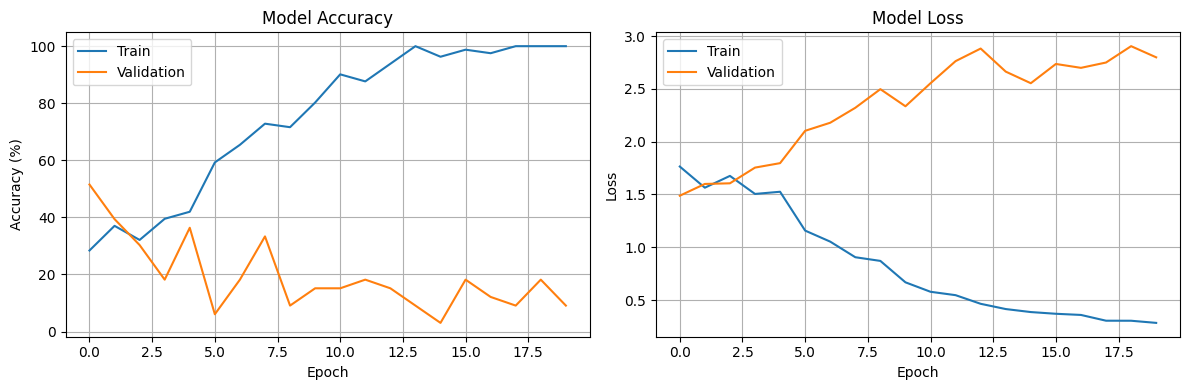

In [91]:
# Plot training history
plot_training_history(history)

**Predict on Test Data**

In [92]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [93]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        # Move to device
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # Get predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [94]:
all_preds, all_labels

([1, 1, 1, 2, 2, 0, 1, 1, 1, 0], [0, 0, 0, 1, 1, 2, 2, 3, 4, 4])

In [95]:
# calculate accuracy
correct_predictions = np.sum(np.array(all_preds) == np.array(all_labels))
accuracy = correct_predictions / len(all_labels)
print(f'Accuracy: {accuracy*100} %')

Accuracy: 0.0 %


In [96]:
# Calculate confusion matrix
class_names = test_loader.dataset.get_class_names()
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, target_names=class_names)

# Print classification report
print("Classification Report")
print(class_report)

Classification Report
                 precision    recall  f1-score   support

      BEER_CANS       0.00      0.00      0.00       3.0
          OTHER       0.00      0.00      0.00       2.0
    PET_BOTTLES       0.00      0.00      0.00       2.0
SHAMPOO_BOTTLES       0.00      0.00      0.00       1.0
   YOGHURT_CUPS       0.00      0.00      0.00       2.0

       accuracy                           0.00      10.0
      macro avg       0.00      0.00      0.00      10.0
   weighted avg       0.00      0.00      0.00      10.0



C:\Users\PK\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\PK\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\PK\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

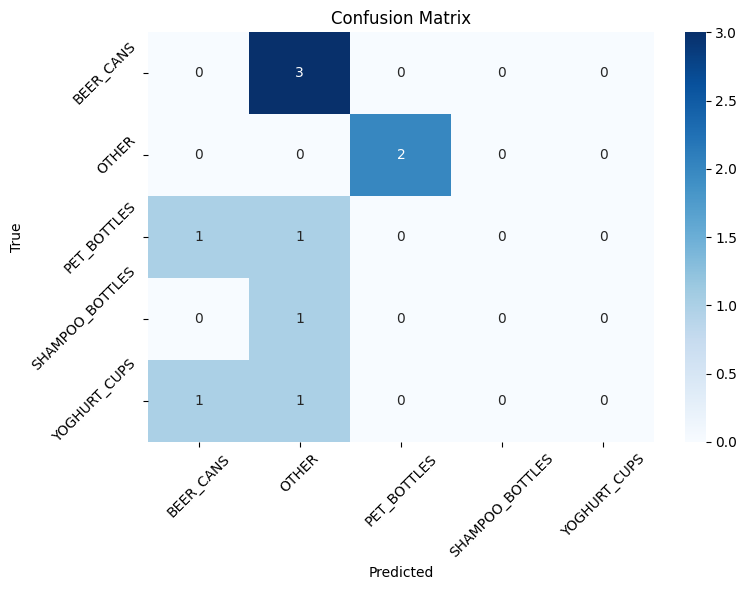

In [97]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
def plot_prediction(dataset: CustomImageDataset, index: int) -> plt.Figure:
    """ Plot a image in the dataset """
    
    img, true_label = test_dataset[index]
    
    # Convert tensor to numpy array for plotting
    # Denormalize the image
    mean = torch.tensor(IMAGE_NET_MEAN).reshape(3, 1, 1)
    std = torch.tensor(IMAGE_NET_STD).reshape(3, 1, 1)
    img = img * std + mean
    
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    plt.figure(figsize=(6, 4))
    plt.imshow(img)
    plt.title(f"True Label: {dataset.get_class_names()[true_label]}")
    plt.show()

**Check on wrong Predictions**

In [99]:
# Identify which gets wrong
wrong_indices = np.where(np.array(all_preds) != np.array(all_labels))[0]
wrong_indices

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

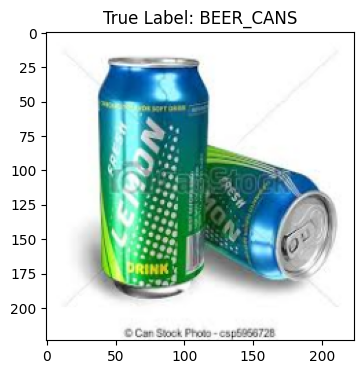

Predicted: 1 True Label: 0
*************************


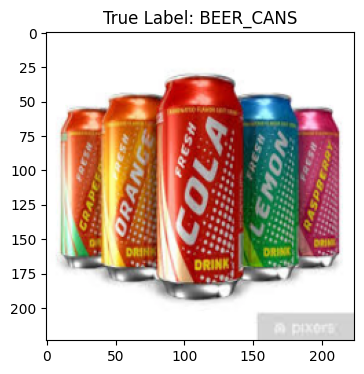

Predicted: 1 True Label: 0
*************************


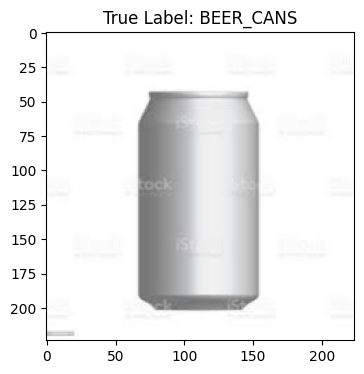

Predicted: 1 True Label: 0
*************************


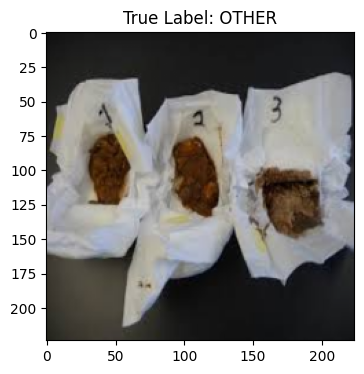

Predicted: 2 True Label: 1
*************************


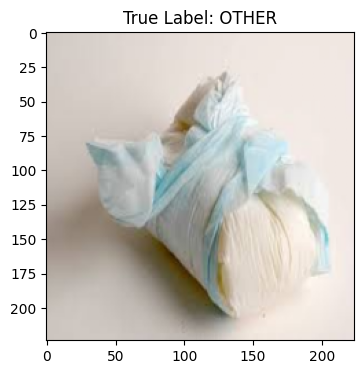

Predicted: 2 True Label: 1
*************************


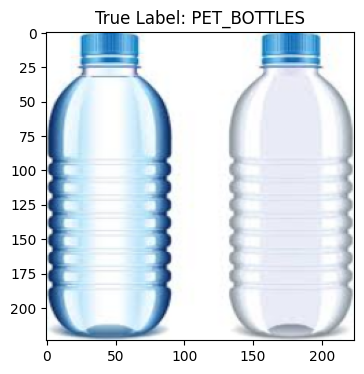

Predicted: 0 True Label: 2
*************************


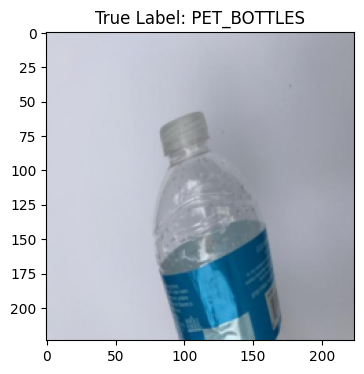

Predicted: 1 True Label: 2
*************************


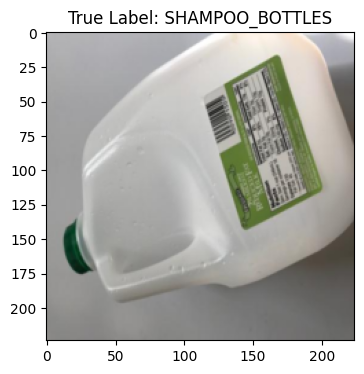

Predicted: 1 True Label: 3
*************************


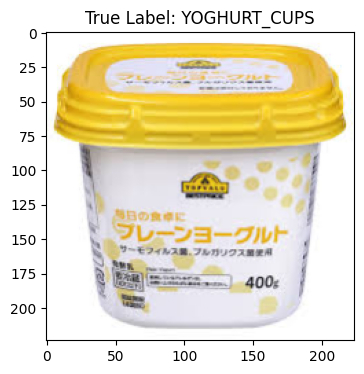

Predicted: 1 True Label: 4
*************************


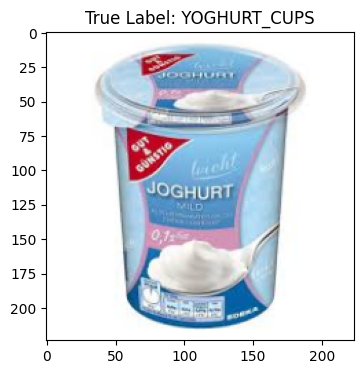

Predicted: 0 True Label: 4
*************************


In [100]:
for idx in wrong_indices:
    plot_prediction(test_dataset, idx)
    print(f'Predicted: {all_preds[idx]} True Label: {all_labels[idx]}')
    print("*"*25)


### **Model Optimization**

1. Convert Model for TorchScript
2. Convert model for FP16 which is faster

In [ ]:
# Load the saved checkpoint
checkpoint = torch.load('runs/dec_1/model_13.pth', map_location='cuda')
model.load_state_dict(checkpoint['model_state_dict'])  # Load the model's weights
model.eval()

# FP16 inference
model = model.half()

## Convert the model to TorchScript
example_input = torch.randn(1, 3, 224, 224).to(DEVICE).half() 
scripted_model = torch.jit.trace(model, example_input)

scripted_model.save('model_scripted.pt')